# Modeling Evaporation and Transpiration

TODO:
* cleaned up until here, 
    * double check the df variable renames got fully renamed (used changed all occurances which can be risky)
    * fix capitalization on the other variables 
    * take out long pathnames and assume local files 
    * get the dataframe column names to be something meaningful
    * maybe break the data into 2 models for some of the null values to get pulled out
    *include data cleaning logic, possibly take it out later

In [20]:
#imports
import pandas as pd
import numpy as np
import math
import numpy
from numpy import random
from scipy.stats import skewnorm
import plotly.graph_objects as go

# Data Import

### Reading in the meterologic data that will be used to train the model

In [21]:
#reading in meterologic data
waseca = pd.read_excel('Data/waseca.xls')
print("Shape of dataframne:", waseca.shape)
waseca.head()

Shape of dataframne: (62, 9)


,date,tmax,tmin,rain,pan,srad,rhmax,rhmin,wd spd
0,1985-06-01,20.3,8.5,0.51,3.81,2.64,94.0,64.0,4.41
1,1985-06-02,15.5,4.5,0.00,3.30,4.85,89.0,45.0,3.65
2,1985-05-03,18.9,5.1,0.00,4.32,5.80,89.0,39.0,2.25
3,1985-06-04,18.3,11.4,0.00,4.32,2.34,83.0,61.0,2.24
4,1985-06-05,23.4,8.1,0.00,8.64,8.51,89.0,22.0,2.53


Initial investigation/cleaning

In [22]:
#checking for nulls
waseca.isnull().any()

date      True
tmax      True
tmin      True
rain      True
pan       True
srad      True
rhmax     True
rhmin     True
wd spd    True
dtype: bool

In [23]:
#looking at how many nulls there are: just 1
waseca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    61 non-null     datetime64[ns]
 1   tmax    61 non-null     float64       
 2   tmin    61 non-null     float64       
 3   rain    61 non-null     float64       
 4   pan     61 non-null     float64       
 5   srad    61 non-null     float64       
 6   rhmax   61 non-null     float64       
 7   rhmin   61 non-null     float64       
 8   wd spd  61 non-null     float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 4.5 KB


In [24]:
#looking for when a metric is null:
waseca[waseca['tmax'].isnull()]

,date,tmax,tmin,rain,pan,srad,rhmax,rhmin,wd spd
30,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

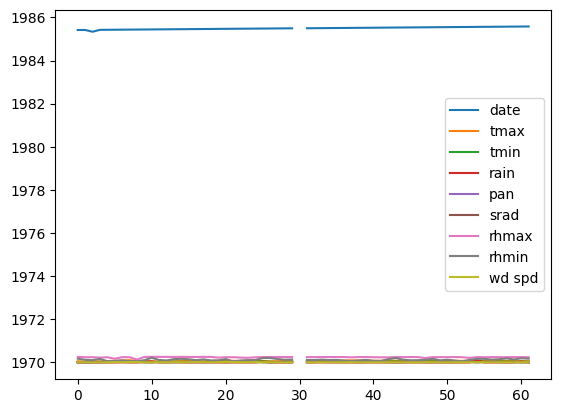

In [25]:
#this looks like a missed point of collection, noting the existence, but I'm not going to pull out 
waseca.plot()

In [26]:
#looks like 30 is the only hole. I will note it's presence and possibly take it out later.

### Reading in observed evapotranspiration data to test model

In [27]:
#reading in observed ET data
observed_et_data_waseca_corn_r204 = pd.read_excel('Data/ObservedET_Waseca_2007.xls', sheet_name = 'Corn_R204')
print("Corn Data frame shape:", observed_et_data_waseca_corn_r204.shape)
observed_et_data_waseca_corn_r204.head(2)

Corn Data frame shape: (195, 7)


,Unnamed: 0,Unnamed: 1,Soil Moisture Content,Unnamed: 3,Unnamed: 4,Unnamed: 5,ET
0,Year,Day,0.2 m,0.4 m,0.8 m,1 m,(mm)
1,2007,120,NaN,NaN,NaN,NaN,NaN


Initial data investigation: can already see existence of nulls and ugly column names

In [28]:
observed_et_data_waseca_corn_r204.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Unnamed: 0             195 non-null    object
 1   Unnamed: 1             195 non-null    object
 2   Soil Moisture Content  137 non-null    object
 3   Unnamed: 3             183 non-null    object
 4   Unnamed: 4             183 non-null    object
 5   Unnamed: 5             181 non-null    object
 6   ET                     24 non-null     object
dtypes: object(7)
memory usage: 10.8+ KB


determining the target datatype for each series. 

In [29]:
#it looks like all columns should be numeric
observed_et_data_waseca_corn_r204.tail()

,Unnamed: 0,Unnamed: 1,Soil Moisture Content,Unnamed: 3,Unnamed: 4,Unnamed: 5,ET
190,2007,309,0.317984,0.40513,0.412569,0.393514,NaN
191,2007,310,0.317179,0.405252,0.412539,0.393645,NaN
192,2007,311,0.317851,0.405344,0.412611,0.393972,NaN
193,2007,312,0.318375,0.404835,0.412321,0.394075,NaN
194,2007,313,0.317351,0.404768,0.412293,0.394331,NaN


In [30]:
#confirming ET not null values are also numeric
observed_et_data_waseca_corn_r204[observed_et_data_waseca_corn_r204['ET'].notnull()]

,Unnamed: 0,Unnamed: 1,Soil Moisture Content,Unnamed: 3,Unnamed: 4,Unnamed: 5,ET
0,Year,Day,0.2 m,0.4 m,0.8 m,1 m,(mm)
68,2007,187,0.340967,0.311142,0.367098,0.392585,4.812324
69,2007,188,0.340014,0.304239,0.356598,0.392595,4.06417
73,2007,192,0.336827,0.329104,0.361436,0.391788,7.137942
74,2007,193,0.336181,0.316313,0.347507,0.39127,5.003881
75,2007,194,0.336038,0.305861,0.338569,0.390798,4.348481
76,2007,195,0.335842,0.296397,0.33182,0.389867,3.906333
77,2007,196,0.336093,0.287876,0.326398,0.38824,3.980225
78,2007,197,0.335985,0.281086,0.32212,0.384973,3.892365
81,2007,200,0.335988,0.33571,0.314833,0.375117,4.622543


In [31]:
#renaming columns and pulling off the first row:
renaming_waseca_corn_columns = {
        'Unnamed: 0': 'year', 
        'Unnamed: 1': 'day', 
        'Soil Moisture Content': 'soil_moist_cont_20_cm', 
        'Unnamed: 3': 'soil_moist_cont_40_cm',
        'Unnamed: 4': 'soil_moist_cont_80_cm', 
        'Unnamed: 5': 'soil_moist_cont_100_cm', 
        'ET': 'et_mm',
    }
observed_et_data_waseca_corn_r204.rename(columns=renaming_waseca_corn_columns,inplace=True)
print(observed_et_data_waseca_corn_r204.shape)
observed_et_data_waseca_corn_r204.drop(index=0,inplace=True)
print("Shape of df after dropping the first row:",observed_et_data_waseca_corn_r204.shape)
observed_et_data_waseca_corn_r204.head()

(195, 7)
Shape of df after dropping the first row: (194, 7)


,year,day,soil_moist_cont_20_cm,soil_moist_cont_40_cm,soil_moist_cont_80_cm,soil_moist_cont_100_cm,et_mm
1,2007,120,NaN,NaN,NaN,NaN,NaN
2,2007,121,NaN,NaN,NaN,NaN,NaN
3,2007,122,NaN,NaN,NaN,NaN,NaN
4,2007,123,NaN,NaN,NaN,NaN,NaN
5,2007,124,NaN,NaN,NaN,NaN,NaN


In [32]:
#looking to see if there is any variance in year
observed_et_data_waseca_corn_r204['year'].value_counts()

year
2007    194
Name: count, dtype: int64

In [33]:
#checking to see if the day ever comes up more than once:
observed_et_data_waseca_corn_r204['day'].value_counts()

day
120    1
265    1
243    1
244    1
245    1
      ..
187    1
188    1
189    1
190    1
313    1
Name: count, Length: 194, dtype: int64

### Reading in weather data observed in 2007

In [34]:
#reading in Weather data observed 2007
observed_weather_waseca_2007 = pd.read_excel('Data/WasecaWeather_2006and2007final.xls', sheet_name = '2007')
print(observed_weather_waseca_2007.shape)
observed_weather_waseca_2007.head()

(155, 12)


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Rain,Unnamed: 5,Pan Evaporation,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Wind
0,NaN,NaN,Tmax,Tmin,Runoff Site,Tile Site,Observed,Est Daily,Radiation,rhmax,rhmin,Speed
1,Year,Day,C,C,mm,mm,mm,mm,MJ/m2/d,%,%,m/s
2,2007,120,23.36,13.92,0,0.254,7.366,3.778189,16.952108,80.25,39.3,2.72
3,2007,121,19.98,9.316,0,NaN,--,7.049334,27.131579,100,76.21,7.041
4,2007,122,20.16,7.134,0,NaN,--,6.948475,25.712393,79.01,59.15,1.674


In [35]:
observed_weather_waseca_2007.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       154 non-null    object
 1   Unnamed: 1       154 non-null    object
 2   Unnamed: 2       155 non-null    object
 3   Unnamed: 3       155 non-null    object
 4   Rain             155 non-null    object
 5   Unnamed: 5       53 non-null     object
 6   Pan Evaporation  155 non-null    object
 7   Unnamed: 7       155 non-null    object
 8   Unnamed: 8       155 non-null    object
 9   Unnamed: 9       155 non-null    object
 10  Unnamed: 10      155 non-null    object
 11  Wind             155 non-null    object
dtypes: object(12)
memory usage: 14.7+ KB


In [36]:
observed_weather_waseca_2007.head(3)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Rain,Unnamed: 5,Pan Evaporation,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Wind
0,NaN,NaN,Tmax,Tmin,Runoff Site,Tile Site,Observed,Est Daily,Radiation,rhmax,rhmin,Speed
1,Year,Day,C,C,mm,mm,mm,mm,MJ/m2/d,%,%,m/s
2,2007,120,23.36,13.92,0,0.254,7.366,3.778189,16.952108,80.25,39.3,2.72


In [37]:
#renaming dict for column in observed_weather_waseca_2007 to be single line evaluations
observed_weather_waseca_2007_columns_rename_dict = {
    'Unnamed: 0': 'year', 
    'Unnamed: 1': 'day', 
    'Unnamed: 2': 'temp_max_celcius', 
    'Unnamed: 3': 'temp_min_celcius', 
    'Rain ': 'rain_runoff_site_mm',
    'Unnamed: 5': 'tile_site_mm', 
    'Pan Evaporation': 'pan_evaporation_observed_mm', 
    'Unnamed: 7': 'est_daily_mm', 
    'Unnamed: 8': 'radiation_megaj_msq_d',
    'Unnamed: 9': 'rhmax_percent', 
    'Unnamed: 10': 'rhmin_percent', 
    'Wind ': 'wind_speed_m_s'
}
observed_weather_waseca_2007.rename(columns=observed_weather_waseca_2007_columns_rename_dict,inplace=True)
print(observed_weather_waseca_2007.shape)
observed_weather_waseca_2007.drop(index=[0,1],inplace=True)
print("Shape of df after dropping the first and second row:",observed_weather_waseca_2007.shape)
observed_weather_waseca_2007.head()

(155, 12)
Shape of df after dropping the first and second row: (153, 12)


,year,day,temp_max_celcius,temp_min_celcius,rain_runoff_site_mm,tile_site_mm,pan_evaporation_observed_mm,est_daily_mm,radiation_megaj_msq_d,rhmax_percent,rhmin_percent,wind_speed_m_s
2,2007,120,23.36,13.92,0,0.254,7.366,3.778189,16.952108,80.25,39.3,2.72
3,2007,121,19.98,9.316,0,NaN,--,7.049334,27.131579,100,76.21,7.041
4,2007,122,20.16,7.134,0,NaN,--,6.948475,25.712393,79.01,59.15,1.674
5,2007,123,21.53,7.63,0,NaN,--,6.346702,16.198613,84.13,61.38,3.963
6,2007,124,16.89,12.18,2.286,2.286,--,4.160045,4.17918,97.59,51.14,6.104


In [38]:
#to get this .iat to be the same number I had to minus the first number by 2 and the column stayed the same, but the .at works fine without it


In [40]:
#updated
ΔTmin = observed_weather_waseca_2007.at[3,'temp_min_celcius']-observed_weather_waseca_2007.at[2,'temp_min_celcius']
ΔTmax = observed_weather_waseca_2007.at[3,'temp_max_celcius']-observed_weather_waseca_2007.at[2,'temp_max_celcius']
print(ΔTmin, ΔTmax)

-4.603999999999999 -3.379999999999999


### Calculating the transition probabilities based on the wet to dry trends

In [43]:
rain = waseca[waseca['rain'].notnull()]['rain']#making sure we're ignoring the 30th day where data wasn't taken:
total_days = len(rain)
#calculating the amount of we days by counting the amount of days that have precip more than 0:
print("total_days: ", total_days)
#creating a counter for the number of instances the amount of rain isn't zero:
wet_days = 0
for rain_amount in rain:
    if rain_amount != 0:
        wet_days +=1
print("wet_days: ", wet_days)

#calculating the amount of dry days by taking the total amount of days and subtracting the wet days
dry_days = total_days-wet_days
print("dry_days: ", dry_days)

#calculating the probabillity of a wet day:
prob_wet_day = wet_days/total_days #See page 2-40 for explanation
print("prob_wet_day: ", prob_wet_day)
#calculating the probability of a dry day:
prob_dry_day = 1-prob_wet_day
print("prob_dry_day: ", prob_dry_day)

#initializing values for transition probability calculations
wet_to_wet = 0
wet_to_dry = 0
dry_to_wet = 1 #we can't compare to day negative one, and so we are assuming the day is dry to match the sums as seen in table 2.2
dry_to_dry = 0
for i in rain.index:
    #accounting for the end of the road (cannot do this calculation bc there is no next day in the dataset):
    if i == total_days:
        #do nothing
        pass
    else:
        j = i+1
        #accouting for 30 being out of commission:
        if j in waseca[waseca['rain'].isnull()].index:
            j+=1
        if(rain[i] !=0 and rain[j]!=0):
            wet_to_wet += 1
        elif(rain[i] !=0 and rain[j]==0):
            wet_to_dry +=1
        elif(rain[i] ==0 and rain[j]!=0):
            dry_to_wet +=1
        else:
            dry_to_dry +=1

print("wet_to_wet: ", wet_to_wet)
print("wet_to_dry: ", wet_to_dry)
print("dry_to_wet: ", dry_to_wet)
print("dry_to_dry: ", dry_to_dry)

#calculating the probability of a wet day to have a next wet day:
p_w_w = wet_to_wet/wet_days
print("p_w_w:", p_w_w)
#calculating the probability of a wet day to have a next dry day:
p_w_d = wet_to_dry/dry_days
print("p_w_d:", p_w_d)
#calculating the probability of a dry day to have a next wet day:
p_d_w = 1-p_w_w
print("p_d_w:",p_d_w)

#to make into a test later:
#Data Check: should be the same 
p_d_w2 = dry_to_wet/wet_days
print(p_d_w2)

#calculating the probability of a dry day to have a next dry day:
p_d_d = 1-p_w_d
print("p_d_d:", p_d_d)
#Data Check
#p_d_d2 = dry_to_dry/dry_days
#print(p_d_d2)

total_days:  61
wet_days:  20
wet day counter: 20
dry_days:  41
prob_wet_day:  0.32786885245901637
prob_dry_day:  0.6721311475409837
wet_to_wet:  8
wet_to_dry:  12
dry_to_wet:  12
dry_to_dry:  29
p_w_w: 0.4
p_w_d: 0.2926829268292683
p_d_w: 0.6
0.6
p_d_d: 0.7073170731707317


In [ ]:
#make a function to calculate Richardson's prediction
#Note: Assume coefficients are the same for rochester MN:Table. 2.4. Cosine Coefficient for Maximum Temperature Statistics, Rochester, MN.

#==================================================================================================================

#========================================================================================================
#Because the first day is dry, we will set the "Global variables" called only on the first iteration of the loop
#we will use the coefficients correlated for the P(W/D)
C0 = 0.225
C1 = -0.059
C2 = 0.008
C3 = 0.008
            
theta1= 0.236
theta2= 0.981
theta3= 0.489
#========================================================================================================
#these get overwritten when in the loop
#================================================================================================================

#===================================
#Period
T=365/(2*math.pi)

#====================================================================================================
#Function to calculate the vday value to compare against the random value to determine if the day will be wet or dry
#==============================================================================================================
def vdaycalc(day,currentState):
        
    if currentState == "wet": # P(W/W) 
        C0 = .392
        C1 = -.035
        C2 = -.055
        C3 = .01
            
        theta1= 0.392 
        theta2= -0.982
        theta3= -0.343 
            
    else: #Current state == dry P(W/D)
        C0 = 0.225
        C1 = -0.059
        C2 = 0.008
        C3 = 0.008
            
        theta1= 0.236
        theta2= 0.981
        theta3= 0.489
    #calculate the Richardson estimation of the parameters based on his eqn 2.5.11:
    vday=float(C0+C1*math.cos(day/T+theta1)+C2*math.cos(2*day/T+theta2)+C3*math.cos(3*day/T+theta3))
    return(vday)

# Calculate If the day is wet or dry
currentStatei = []
currentState = "dry" #chosen such that the above transition probabilities would sum correctly
precip = []
for day in range(366):
    #call the Richardson estimation function inside the loop
    vday=vdaycalc(day,currentState)
    randomdayvalue=random.random()
    if vday==randomdayvalue:
        print('something is wrong')
    elif randomdayvalue>vday:
        nextday = "dry"
        P=0
    else:
        #estimated based on the vday equation and the respective coefficient from the data given 
        mu = float(C0+C1*math.cos(day/T+theta1)+C2*math.cos(2*day/T+theta2)+C3*math.cos(3*day/T+theta3))
        #Changed the precip to fit a skewed normal estimation based on Bruce's office hours
        P=mu*float(skewnorm.rvs(a=2, size=1)) #mm
        #possible source of error: forcing to positive
        if P<0:
            P=abs(mu*float(skewnorm.rvs(a=2, size=1))) #mm
        nextday = "wet"
    precip.append(P)
    currentStatei.append(currentState)
    currentState=nextday
    
yearRecord = pd.DataFrame(
    {'Current State': currentStatei,
     'Precip': precip
    })

N = 365
t = numpy.linspace(0, 1, 365)

print(yearRecord)
#Simulated precip
fig = go.Figure(data=go.Scatter(x=t, y=precip, mode='markers'))

fig.show()

In [ ]:
#Infiltration component

#May 39th is the 150th day of the year, pull 151 column for soil moisture information as initial
initialsoilmoisturecontent = float(observed_et_data_waseca_corn_r204.at[31,'Soil Moisture Content'])
#alternative initial estimation method:
#θi = θwp+0.5*(θfc-θwp) #initial state of the soil moisture
#=====================================================================================================
# Parameter estimation
#soil tank depth mm to correlate to the soil information for the Nicollet Clay Loam at .2 m
#soil information from table given in the site
D=200
θs=0.48
θfc=0.41
θwp=0.26
b=13.4
Ψb=108 #mm of H20
Ks = 55.2 #mm/d saturated conductivity
θi=initialsoilmoisturecontent #global variable to use for the first iteration in the look
#======================================================================================================

#====================================================================================================
#Calculating net infiltration and percolation
#=====================================================================================================
def calcfp(day):
    Net_Inf_Per = (θfc-θi)*D
    if precip[day]<Net_Inf_Per:
        #precip[day] = precipitation simulated for that day
        Net_Inf_Per = precip[day]
    return Net_Inf_Per

#====================================================================================================
#Calculating Net Radiation
#assuming the same parameters given on page 6-50 for grass conditions
#=====================================================================================================
bo = -0.52 #MJ/m2/d 
b1 = 0.75 #MJ/m2/d
def calcRn(day):
    row = day-118
    Rsi=float(observed_weather_waseca_2007.at[row,'Unnamed: 8'])
    Rn = bo+b1*Rsi
    return Rn

#====================================================================================================
#Calculating RET Using Penmans
#referencing page  6-50; 6-82 for algorithm summary
#=====================================================================================================
γc = 0.066 #kPa/K = 0.66 mbar/K.
L = 2453 #MJ m-3
G=0 #for a daily time step
cp = 1 #kJ kg-1 K-1
#Compute log profile resistance constant:
def calcΨRET(day):
    rowcurrentday=day-118
    rowyesterday=day-119
    ΔTmin = observed_weather_waseca_2007.at[rowcurrentday,'Unnamed: 3']-observed_weather_waseca_2007.at[rowyesterday,'Unnamed: 3']
    ΔTmax = observed_weather_waseca_2007.at[rowcurrentday,'Unnamed: 2']-observed_weather_waseca_2007.at[rowyesterday,'Unnamed: 2']
    Δhat = (ΔTmin+ΔTmax)/2 #C
    U2= observed_weather_waseca_2007.iat[rowcurrentday,11] #km d-1
    fu= 6.43*(1+0.0062*U2) #MJ m-2 d-1 kPa-1
    esatmin=((observed_weather_waseca_2007.at[rowcurrentday,'Unnamed: 3']+273.15)/273.16)**(-4.811)*math.exp(24.134-6726.73/(observed_weather_waseca_2007.at[rowcurrentday,'Unnamed: 3']+273.15)) #Kpa eqn 6.4.2
    esatmax=((observed_weather_waseca_2007.at[rowcurrentday,'Unnamed: 2']+273.15)/273.16)**(-4.811)*math.exp(24.134-6726.73/(observed_weather_waseca_2007.at[rowcurrentday,'Unnamed: 2']+273.15)) #Kpa eqn 6.4.2
    rhmax=observed_weather_waseca_2007.at[rowcurrentday,'Unnamed: 9']/100
    rhmin=observed_weather_waseca_2007.at[rowcurrentday,'Unnamed: 10']/100
    dailyvaporpressuredeficit=(esatmax+esatmax)/2-(esatmin*rhmax+esatmax*rhmin)/2
    ΨRET=Δhat/(Δhat+γc)*(calcRn(day)-G)+γc/(Δhat+γc)*fu*dailyvaporpressuredeficit
    return ΨRET

def calcRETpenm(day):
    RET=calcΨRET(day)/L
    return RET

def calcET(day):
    
    #calculating soil moisture availability factor
    #Coefficient of rapid evaporation loss
    #look up Kr: http://www.fao.org/3/X0490e/x0490e0c.htm from generalized figure
    if θi>θfc:
        Kw=1
        #Kr=1
    elif θi<θwp:
        Kw=0
        #Kr=.4
    else:
        Aw=100*(θi-θwp)/(θfc-θwp)
        Kw=np.log(Aw+1)/np.log(101)
        #Kr=.7
        
    #crop coefficient for corn
    Kc = .3 #table 6.6
    
    
    ET=(Kc*Kw)*calcRETpenm(day)
    return ET
    

#====================================================================================================
#Calculating soil moisture content Penman
#=====================================================================================================
def calcθi(day,θi):
    θi=θi+calcfp(day)/D-calcET(day)/D
    return θi

#Pan Method
Kc = .3 #table 6.6
#====================================================================================================
#Pan Evap Method
#=====================================================================================================
def calcETpanmeth(day):
    row=day-118
    RET=cp*observed_weather_waseca_2007.at[row,'Unnamed: 7']
        
    PET=Kc*RET
    if θi>θfc:
        Kw=1
        #Kr=1
    elif θi<θwp:
        Kw=0
       #Kr=.4
    else:
        Aw=100*(θi-θwp)/(θfc-θwp)
        Kw=np.log(Aw+1)/np.log(101)
        Kr=.7
        
    #crop coefficient for corn
    ET=Kw*PET
    return ET

#====================================================================================================
#Calculating soil moisture content Pan evap method
#=====================================================================================================
def calcθipan(day,θi):
    θi=θi+calcfp(day)/D-calcETpanmeth(day)/D
    return θi


ETpan= []
soilmoisturepan = []
soilmoistureContent = []
ETlist = []
infilperclist=[]

for day in range(152,273,1):
    ET = 1000*calcET(day)
    ETlist.append(ET)
    fp=calcfp(day)
    infilperclist.append(fp)
    θi = calcθi(day,θi)
    soilmoistureContent.append(θi)
    ETPan = calcETpanmeth(day)
    ETpan.append(ETPan)
    θPan =  calcθipan(day,θi)
    soilmoisturepan.append(θPan)
    
df = pd.DataFrame({'ET Penman':ETlist, 'θ Penman':soilmoistureContent, 'ET Pan':ETpan, 'θ Pan':soilmoisturepan})
print(df)

observedsoilmoisture= observed_et_data_waseca_corn_r204['Unnamed: 3'].values.tolist()
observedET= observed_et_data_waseca_corn_r204['ET'].values.tolist()


t = numpy.linspace(152, 273, 121)
soilmoisture = go.Figure(data=go.Scatter(x=t, y=soilmoistureContent, name='Soil Moisture Content Penman', mode='markers'))
soilmoisture.add_trace(go.Scatter(x=t, y=soilmoisturepan, name='Soil Moisture Content Pan Evap', mode='markers'))
soilmoisture.add_trace(go.Scatter(x=t, y=observedsoilmoisture, name='Soil Moisture Content observed', mode='markers'))
soilmoisture.show()

ET = go.Figure(data=go.Scatter(x=t, y=ETlist, name='ET Penman', mode='markers', marker_color='rgba(152, 0, 0, .8)'))
ET.add_trace(go.Scatter(x=t, y=ETpan, name='ET pan', mode='markers'))
ET.add_trace(go.Scatter(x=t, y=observedET, name='ET Observed', mode='markers'))
ET.show()

#ET.write_html(r'C:\Users\clair\Downloads\ETgraph.html')
#soilmoisture.write_html(r'C:\Users\clair\Downloads\soilmoisturegraph.html')

In [ ]:
#With actual precip data

initialsoilmoisturecontent = float(observed_et_data_waseca_corn_r204.at[31,'Soil Moisture Content'])
#alternative initial estimation method:
#θi = θwp+0.5*(θfc-θwp) #initial state of the soil moisture
#=====================================================================================================
# Parameter estimation
#soil tank depth mm to correlate to the soil information for the Nicollet Clay Loam at .2 m
#soil information from table given in the site
D=200
θs=0.48
θfc=0.41
θwp=0.26
b=13.4
Ψb=108 #mm of H20
Ks = 55.2 #mm/d saturated conductivity
θi=initialsoilmoisturecontent #global variable to use for the first iteration in the look
#======================================================================================================

#====================================================================================================
#Calculating net infiltration and percolation
#=====================================================================================================
def calcfp(day):
    Net_Inf_Per = (θfc-θi)*D
    if actualprecip[day-150]<Net_Inf_Per:
        #precip[day] = precipitation simulated for that day
        Net_Inf_Per = precip[day]
    return Net_Inf_Per

#====================================================================================================
#Calculating Net Radiation
#assuming the same parameters given on page 6-50 for grass conditions
#=====================================================================================================
bo = -0.52 #MJ/m2/d 
b1 = 0.75 #MJ/m2/d
def calcRn(day):
    row = day-118
    Rsi=float(observed_weather_waseca_2007.at[row,'Unnamed: 8'])
    Rn = bo+b1*Rsi
    return Rn

#====================================================================================================
#Calculating RET Using Penmans
#referencing page  6-50; 6-82 for algorithm summary
#=====================================================================================================
γc = 0.066 #kPa/K = 0.66 mbar/K.
L = 2453 #MJ m-3
G=0 #for a daily time step
cp = 1 #kJ kg-1 K-1
#Compute log profile resistance constant:
def calcΨRET(day):
    rowcurrentday=day-118
    rowyesterday=day-119
    ΔTmin = observed_weather_waseca_2007.at[rowcurrentday,'Unnamed: 3']-observed_weather_waseca_2007.at[rowyesterday,'Unnamed: 3']
    ΔTmax = observed_weather_waseca_2007.at[rowcurrentday,'Unnamed: 2']-observed_weather_waseca_2007.at[rowyesterday,'Unnamed: 2']
    Δhat = (ΔTmin+ΔTmax)/2 #C
    U2= observed_weather_waseca_2007.iat[rowcurrentday,11] #km d-1
    fu= 6.43*(1+0.0062*U2) #MJ m-2 d-1 kPa-1
    esatmin=((observed_weather_waseca_2007.at[rowcurrentday,'Unnamed: 3']+273.15)/273.16)**(-4.811)*math.exp(24.134-6726.73/(observed_weather_waseca_2007.at[rowcurrentday,'Unnamed: 3']+273.15)) #Kpa eqn 6.4.2
    esatmax=((observed_weather_waseca_2007.at[rowcurrentday,'Unnamed: 2']+273.15)/273.16)**(-4.811)*math.exp(24.134-6726.73/(observed_weather_waseca_2007.at[rowcurrentday,'Unnamed: 2']+273.15)) #Kpa eqn 6.4.2
    rhmax=observed_weather_waseca_2007.at[rowcurrentday,'Unnamed: 9']/100
    rhmin=observed_weather_waseca_2007.at[rowcurrentday,'Unnamed: 10']/100
    dailyvaporpressuredeficit=(esatmax+esatmax)/2-(esatmin*rhmax+esatmax*rhmin)/2
    ΨRET=Δhat/(Δhat+γc)*(calcRn(day)-G)+γc/(Δhat+γc)*fu*dailyvaporpressuredeficit
    return ΨRET

def calcRETpenm(day):
    RET=calcΨRET(day)/L
    return RET

def calcET(day):
    
    #calculating soil moisture availability factor
    #Coefficient of rapid evaporation loss
    #look up Kr: http://www.fao.org/3/X0490e/x0490e0c.htm from generalized figure
    if θi>θfc:
        Kw=1
        #Kr=1
    elif θi<θwp:
        Kw=0
        #Kr=.4
    else:
        Aw=100*(θi-θwp)/(θfc-θwp)
        Kw=np.log(Aw+1)/np.log(101)
        #Kr=.7
        
    #crop coefficient for corn
    Kc = .3 #table 6.6
    
    
    ET=(Kc*Kw)*calcRETpenm(day)
    return ET
    

#====================================================================================================
#Calculating soil moisture content Penman
#=====================================================================================================
def calcθi(day,θi):
    θi=θi+calcfp(day)/D-calcET(day)/D
    return θi

#Pan Method
Kc = .3 #table 6.6
#====================================================================================================
#Pan Evap Method
#=====================================================================================================
def calcETpanmeth(day):
    row=day-118
    RET=cp*observed_weather_waseca_2007.at[row,'Unnamed: 7']
        
    PET=Kc*RET
    if θi>θfc:
        Kw=1
        #Kr=1
    elif θi<θwp:
        Kw=0
       #Kr=.4
    else:
        Aw=100*(θi-θwp)/(θfc-θwp)
        Kw=np.log(Aw+1)/np.log(101)
        Kr=.7
        
    #crop coefficient for corn
    ET=Kw*PET
    return ET

#====================================================================================================
#Calculating soil moisture content Pan evap method
#=====================================================================================================
def calcθipan(day,θi):
    θi=θi+calcfp(day)/D-calcETpanmeth(day)/D
    return θi


ETpan= []
soilmoisturepan = []
soilmoistureContent = []
ETlist = []
infilperclist=[]

for day in range(152,273,1):
    ET = 1000*calcET(day)
    ETlist.append(ET)
    fp=calcfp(day)
    infilperclist.append(fp)
    θi = calcθi(day,θi)
    soilmoistureContent.append(θi)
    ETPan = calcETpanmeth(day)
    ETpan.append(ETPan)
    θPan =  calcθipan(day,θi)
    soilmoisturepan.append(θPan)
    
df = pd.DataFrame({'ET Penman':ETlist, 'θ Penman':soilmoistureContent, 'ET Pan':ETpan, 'θ Pan':soilmoisturepan})
print(df)

observedsoilmoisture= observed_et_data_waseca_corn_r204['Unnamed: 3'].values.tolist()
observedET= observed_et_data_waseca_corn_r204['ET'].values.tolist()


t = numpy.linspace(152, 273, 121)
soilmoisture = go.Figure(data=go.Scatter(x=t, y=soilmoistureContent, name='Soil Moisture Content Penman', mode='markers'))
soilmoisture.add_trace(go.Scatter(x=t, y=soilmoisturepan, name='Soil Moisture Content Pan Evap', mode='markers'))
soilmoisture.add_trace(go.Scatter(x=t, y=observedsoilmoisture, name='Soil Moisture Content observed', mode='markers'))
soilmoisture.show()

ET = go.Figure(data=go.Scatter(x=t, y=ETlist, name='ET Penman', mode='markers', marker_color='rgba(152, 0, 0, .8)'))
ET.add_trace(go.Scatter(x=t, y=ETpan, name='ET pan', mode='markers'))
ET.add_trace(go.Scatter(x=t, y=observedET, name='ET Observed', mode='markers'))
ET.show()

#ET.write_html(r'C:\Users\clair\Downloads\ETgraph.html')
#soilmoisture.write_html(r'C:\Users\clair\Downloads\soilmoisturegraph.html')